<a href="https://colab.research.google.com/github/TajikDanyal/Brats/blob/master/Brats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/2019/MICCAI_BraTS_2019_Data_Training.zip

--2019-09-19 05:09:36--  https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/2019/MICCAI_BraTS_2019_Data_Training.zip
Resolving www.cbica.upenn.edu (www.cbica.upenn.edu)... 165.123.244.124
Connecting to www.cbica.upenn.edu (www.cbica.upenn.edu)|165.123.244.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2759083030 (2.6G) [application/zip]
Saving to: ‘MICCAI_BraTS_2019_Data_Training.zip’

MICCAI_BraTS_2019_D 100%[===================>]   2.57G  36.4MB/s    in 77s     

2019-09-19 05:10:53 (34.2 MB/s) - ‘MICCAI_BraTS_2019_Data_Training.zip’ saved [2759083030/2759083030]



In [0]:
from zipfile import ZipFile
zip = ZipFile('MICCAI_BraTS_2019_Data_Training.zip')
zip.extractall()

In [3]:
import os
import numpy as np
import nibabel as nib
import random
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import Sequence
import cv2

Using TensorFlow backend.


In [0]:
PATH = "/content/MICCAI_BraTS_2019_Data_Training/HGG/"

In [0]:
class MyGenerator(Sequence):
    def __init__(self, Path, Directory):
        self.Path=Path
        self.Folders=Directory
    def __len__(self):
        return len(self.Folders)
    def __getitem__(self, idx):
      return ReadImageDataFromFolderFiles(self.Folders[idx])
       
         

In [0]:
def ReadDataset(Path):
    return os.listdir(Path)

In [0]:
def SetLabel(FileName):
    if"t1." in FileName :
        return "T1"
    elif "t1ce." in FileName:
        return "T1CE"
    elif "seg." in FileName:
        return "Segmented"
    elif "flair." in FileName:
        return "Flair"
    elif "t2." in FileName:
        return "T2"
    return "Undefined"

In [0]:
def ReadImageDataFromFolderFiles(FolderName):
  
    im_Size=240
    Files = os.listdir(PATH+FolderName)
    Files.sort()
    Images = [nib.load( PATH+FolderName+"/"+File ).get_fdata() for File in Files]
    XData = np.zeros( (Images[0].shape[2], im_Size, im_Size, 4) )
    YData = np.zeros( (Images[0].shape[2], im_Size, im_Size, 1) )
    for i in range(Images[0].shape[2]):
        XData[i,:,:,0] = cv2.resize(Images[0][:,:,i], (im_Size,im_Size), interpolation = cv2.INTER_AREA) 
        XData[i,:,:,1] = cv2.resize(Images[2][:,:,i], (im_Size,im_Size), interpolation = cv2.INTER_AREA) 
        XData[i,:,:,2] = cv2.resize(Images[3][:,:,i], (im_Size,im_Size), interpolation = cv2.INTER_AREA) 
        XData[i,:,:,3] = cv2.resize(Images[4][:,:,i], (im_Size,im_Size), interpolation = cv2.INTER_AREA) 
        YData[i,:,:,0] = cv2.resize(Images[1][:,:,i], (im_Size,im_Size), interpolation = cv2.INTER_AREA) 
    return XData/65535, YData/65535

In [0]:
def DisplaySample(FolderName, index):
    print("****IN: "+str(index+1)+" PATH="+PATH+FolderName+"****")
    Files = os.listdir(PATH+FolderName)
    fig, axes = plt.subplots(1, len(Files))
    count=0
    TempFiles=Files
    TempFiles.sort()
    for File in Files:
        img = nib.load(PATH+FolderName+"/"+File)
        #print (img)
        img_data = img.get_fdata()
        #img_data = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #raise ValueError(img_data.shape)
        axes[count].title.set_text(SetLabel(File))
        axes[count].imshow(img_data[:,:,77].T, aspect="equal",  interpolation='nearest', origin="lower")
        count+=1
    plt.show()

In [0]:
def DisplayOutput(Predicted):
  fig, axes = plt.subplots(1,1)
  for i in range(0,Predicted.shape[0]):
    plt.imshow(Predicted[i,:,:,0])
    plt.show()
        

In [0]:
def AnimateSample(FolderName, index):
    print("****IN: "+str(index+1)+" PATH="+PATH+FolderName+"****")
    Files = os.listdir(PATH+FolderName)
    TempFiles=Files
    TempFiles.sort()
    for File in Files:
        img = nib.load(PATH+FolderName+"/"+File)
        img_data = img.get_fdata()
        #raise ValueError()
        
        for i in range(img.shape[2]):
            plt.imshow(img_data[:,:,i].T)
            plt.title(File)
            plt.show()


In [0]:
def Split(Folders, Ratio=0.8):
    random.shuffle(Folders)
    Train = []
    Test = []
    Valid = []
    SplitPoint = int(Ratio*len(Folders))
    Train = Folders[0:SplitPoint]
    Test = Folders[SplitPoint:len(Folders)]
    SplitPoint = int(Ratio*len(Train))
    Valid = Train[SplitPoint:len(Train)]
    Train = Train[0:SplitPoint]
    return Train, Test, Valid

In [0]:
def PreProcessAndPrepareDataset(Path):
    Folders=ReadDataset(Path)
    X = np.zeros((len(Folders),155*5,240,240))
    for Folder in Folders:
        ImageList = ReadImageDataFromFolderFiles(Folder)
        ImageArray = np.asarray(ImageList)
        print(ImageArray.shape)
        ImageArray = ImageArray.reshape((155*5,240,240))
        raise ValueError(ImageArray.shape)

In [0]:
def DownSample1(Input, NumConvFilters, ConvFilterSize, MaxPoolSize, Activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(Input)
  conv2 = Conv2D(NumConvFilters, ConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(MaxPoolSize, MaxPoolSize))(conv2)
  return conv2, pool1

def DownSample2(Input, NumConvFilters, ConvFilterSize, MaxPoolSize, Activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(Input)
  return DownSample1(conv1, NumConvFilters, ConvFilterSize, MaxPoolSize, Activation, Padding)
   
def UpSample2(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, Activation="relu", Padding="same"):
  Unpool1 = UpSampling2D(size = (UnpoolSize,UnpoolSize))(Input)
  concat = Concatenate()([Unpool1, SkipConnections])
  conv1 = Conv2D(NumDeConvFilters, DeConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(concat)
  conv2 = Conv2D(NumDeConvFilters, DeConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(conv1)
  return conv2

def UpSample1(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, Activation="relu", Padding="same"):
  Up1 = UpSample2(Input, SkipConnections, NumDeConvFilters, DeConvFilterSize, UnpoolSize, Activation, Padding)
  return Conv2D(NumDeConvFilters, DeConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(Up1)
  
def BottleNeck(Input, NumConvFilters, ConvFilterSize, Activation="relu", Padding="same"):
  conv1 = Conv2D(NumConvFilters, ConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(Input)
  return Conv2D(NumConvFilters, ConvFilterSize, activation = Activation, padding = Padding, kernel_initializer = 'he_normal')(conv1)
  
  
def MyModel(InputSize, NumberOfFilters = [8, 16, 32, 64, 128], FilterSize = 3, PoolSize = 2):
  inputs = Input(InputSize)
  #################################ENCODER NETWORK START########################
  Skip1, DS1 = DownSample1(inputs, NumberOfFilters[0], FilterSize,PoolSize) # 120
  Skip2, DS2 = DownSample1(DS1, NumberOfFilters[1], FilterSize,PoolSize) # 60
  Skip3, DS3 = DownSample2(DS2, NumberOfFilters[2], FilterSize,PoolSize) #30
  Skip4, DS4 = DownSample2(DS3, NumberOfFilters[3], FilterSize,PoolSize) #15
  #Skip5, DS5 = DownSample2(DS4, 1024,3,2)
  #################################ENCODER NETWORK END###########################
  #################################BOTTLENECK START##############################
  
  BN = BottleNeck(DS4, NumberOfFilters[4], FilterSize)
  
  #################################BOTTLENECK END################################
  #################################DECODER NETWORK START#########################
  #US1=UpSample1(BN, Skip5,1024, 3, 2)
  US2=UpSample1(BN, Skip4, NumberOfFilters[3], FilterSize, PoolSize)
  US3=UpSample1(US2, Skip3, NumberOfFilters[2], FilterSize, PoolSize)
  US4=UpSample2(US3, Skip2, NumberOfFilters[1], FilterSize, PoolSize)
  US5=UpSample2(US4, Skip1, NumberOfFilters[0], FilterSize, PoolSize)
  #################################DECODER NETWORK END###########################
  #################################OUTPUT  LAYER START###########################
  Out = Conv2D(1, 1, activation = 'sigmoid')(US5)
  #################################OUTPUT LAYER END##############################
  model = Model(input = inputs, output = Out)
  
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
Folders = ReadDataset(PATH)

Train, Test, Valid = Split(Folders, 0.8)
TrainGenerator = MyGenerator(PATH, Train)
ValidGenerator = MyGenerator(PATH, Valid)
TestGenerator = MyGenerator(PATH, Test)
#
#Model.summary()
#from keras.utils import plot_model
#plot_model(Model, to_file='model.png')

#
#for Index, Folder in enumerate(Folders):
#     AnimateSample(Folders[0], 0)


****IN: 1 PATH=/content/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_ASA_1****


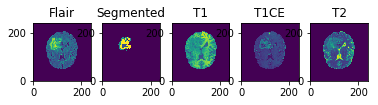

In [17]:
Train[0]
DisplaySample(Train[100],0)

In [18]:
Model=MyModel(InputSize = (240,240,4))
print(Train[0])
X, Y = TrainGenerator.__getitem__(0)
Model.fit(X,Y, epochs=500)
#Model.fit_generator(TrainGenerator, epochs = 10, validation_data=ValidGenerator)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
BraTS19_TCIA04_149_1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/500
155/155 [==============================] - 11s 70ms/step - loss: 0.6928 - acc: 0.7186
Epoch 2/500
155/155 [==============================] - 1s 6ms/step - loss: 0.6905 - acc: 0.9838
Epoch 3/500
155/155 [==============================] - 1s 6ms/step - loss: 0.6863 - acc: 0.9918
Epoch 4/500
155/155 [==============================] - 1s 6ms/step - loss: 0.6772 - acc: 0.9922
Epoch 5/500
155/155 [==============================] - 1s 6ms/step - loss: 0.6405 - acc: 0.9922
Epoch 6/500
155/155 [==============================] - 1s 6ms/step - loss: 0.5013 - acc: 0.9922
Epoch 7/500
155/155 [==============================] - 1s 6ms/step - loss: 0.1928 - acc: 0.9921
Epoch 8/500
155/155 [==============================] - 1s 6ms/step - loss: 0.0256 - acc: 0.9921
Epoch 9/500
155/155 [==============================] - 1s 6ms/step - loss: 0.0048 - acc: 0.9921
Epoch 10/500
155/155 [==============================] - 1s 6ms/step - loss: 0.0011 - acc: 0.9921
Epoch 11/500
155/155 [===============

KeyboardInterrupt: ignored

In [0]:
#TestGenerator = MyGenerator(PATH, Test)
#X, Y = TestGenerator.__getitem__(0)
#raise ValueError(X.shape)

Out = Model.predict(np.expand_dims(X[77,:,:,:],0))

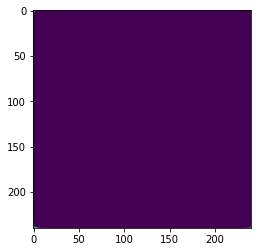

In [21]:
DisplayOutput(Out)